<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Mahshad Moradi
### Student ID: 400109373

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 78432899.27it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 75994789.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31091740.94it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16171925.95it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

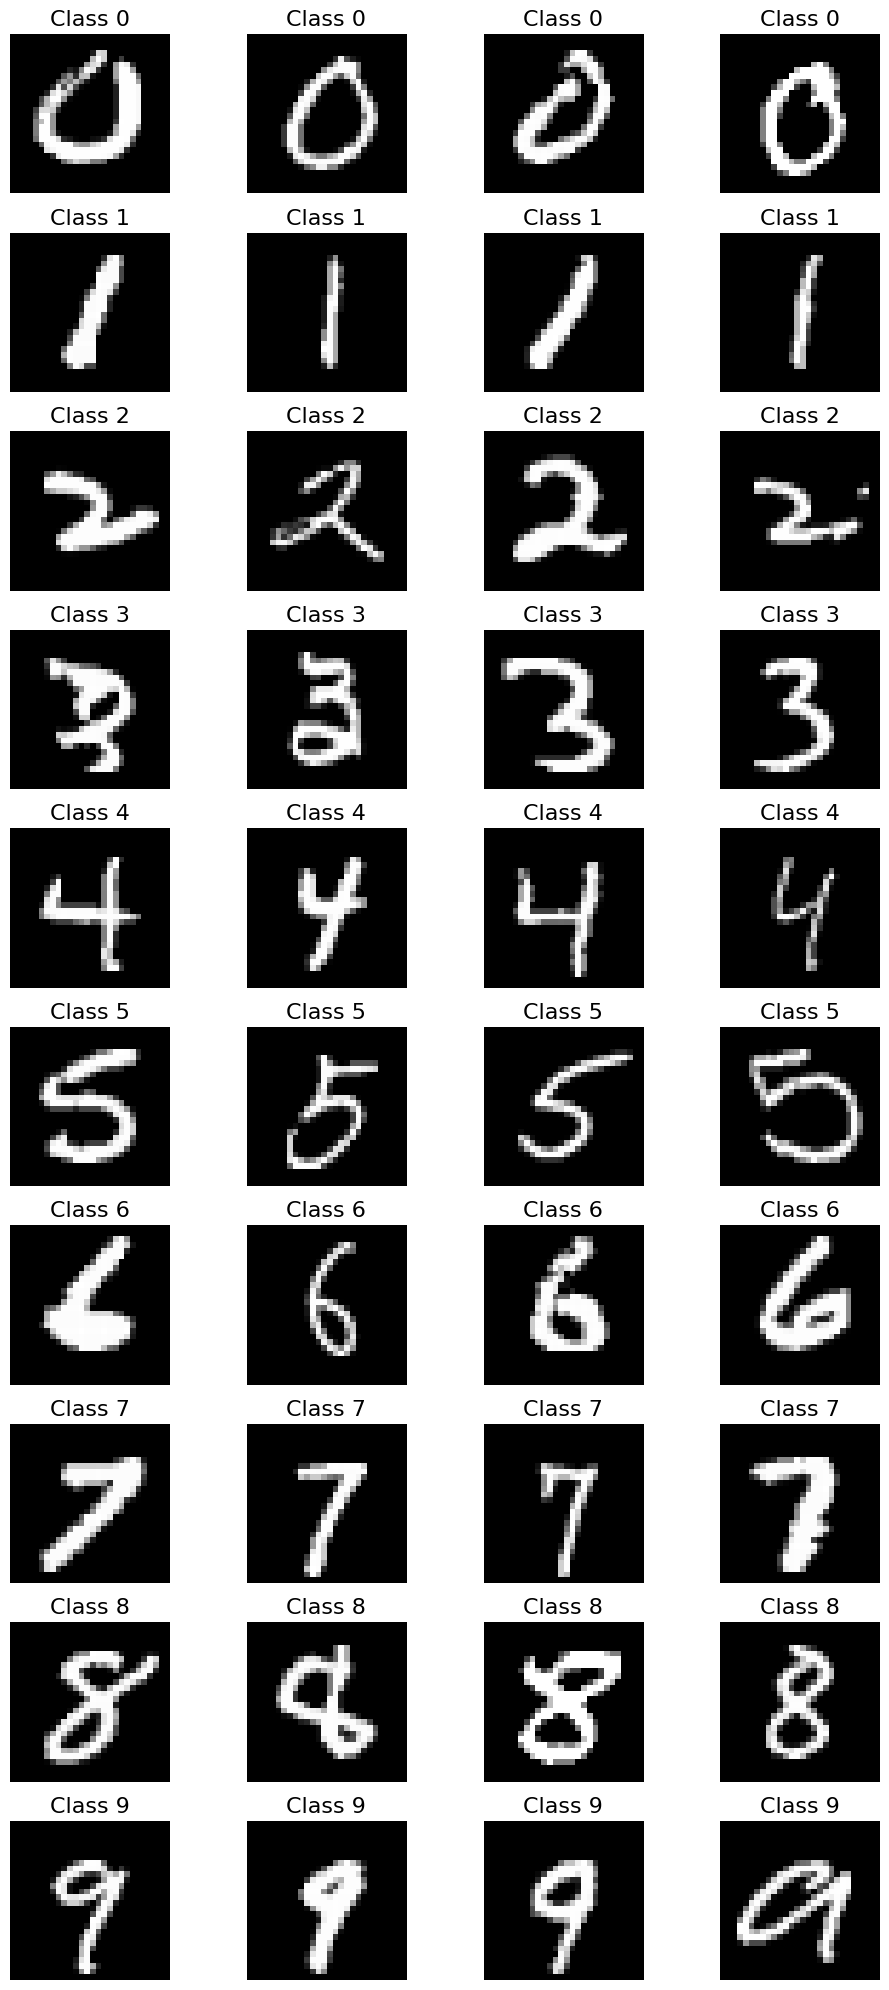

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [5]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Use Sigmoid to output values between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # TODO: Implement the forward pass
        # Encoder
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decoder
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

In [6]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')
    # F.mse_loss(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    return reconstruction_loss + kl_divergence

In [7]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process

            # TODO: Flatten the data and recon tensors
            data = data.view(data.size(0), -1)  # Flatten the data
            recon, mu, logvar = model(data)  # Forward pass

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()  # Clear existing gradients
            loss.backward()        # Compute gradients of all variables wrt loss
            optimizer.step()       # Perform updates using calculated gradients

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 171.9213873372396
Sample Images:


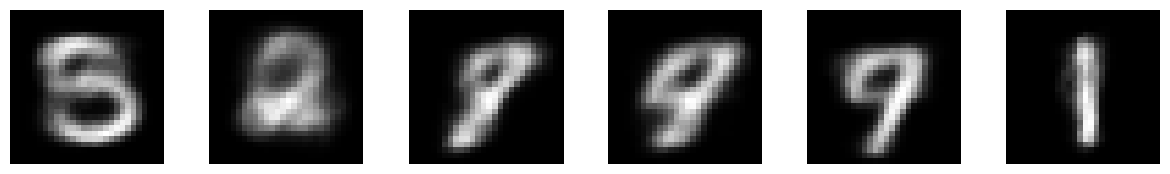


##################################################
VAE-MLP Epoch [2/10], Loss: 154.2529750325521
Sample Images:


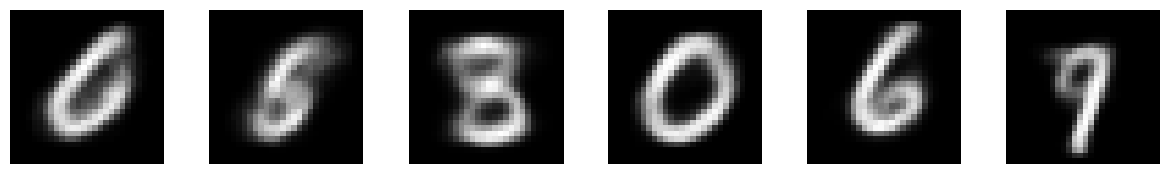


##################################################
VAE-MLP Epoch [3/10], Loss: 150.35436097005208
Sample Images:


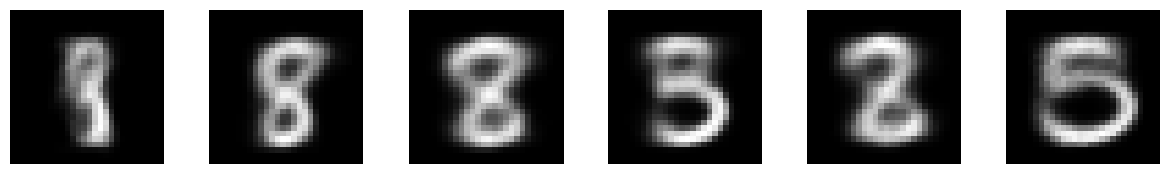


##################################################
VAE-MLP Epoch [4/10], Loss: 147.80231182454426
Sample Images:


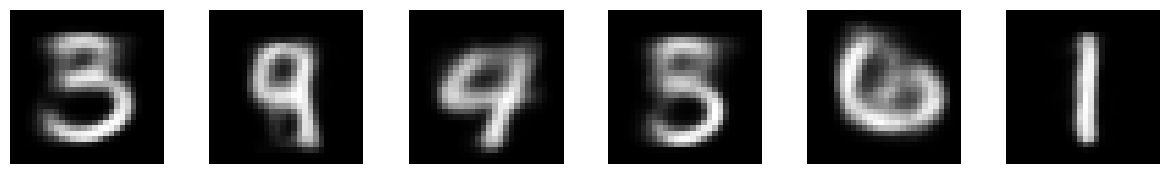


##################################################
VAE-MLP Epoch [5/10], Loss: 146.41859431966145
Sample Images:


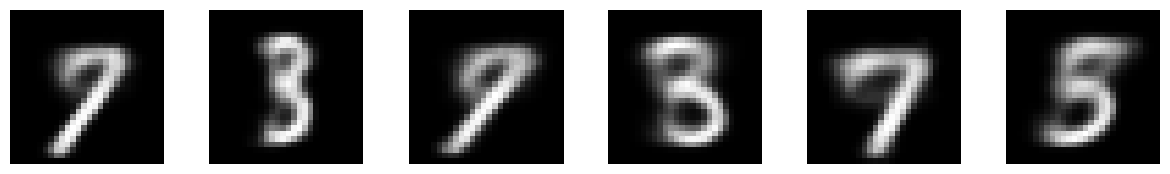


##################################################
VAE-MLP Epoch [6/10], Loss: 145.22109576822916
Sample Images:


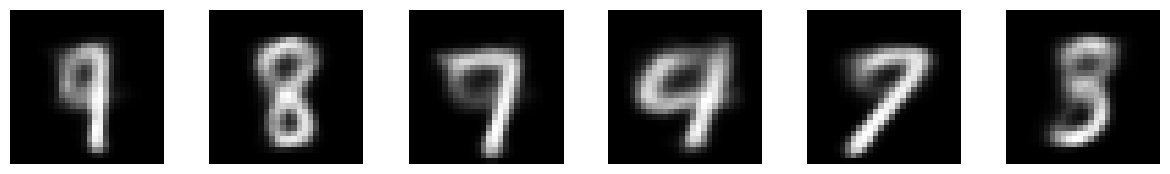


##################################################
VAE-MLP Epoch [7/10], Loss: 144.32720222981771
Sample Images:


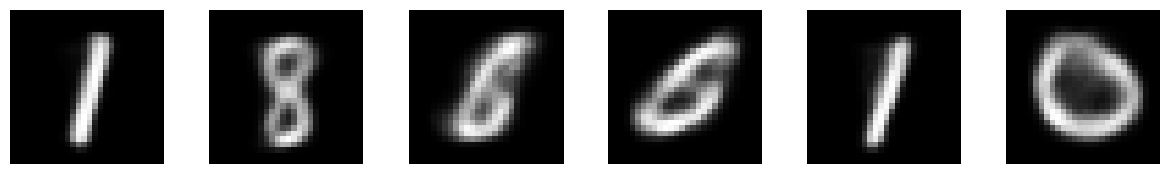


##################################################
VAE-MLP Epoch [8/10], Loss: 143.8332083902995
Sample Images:


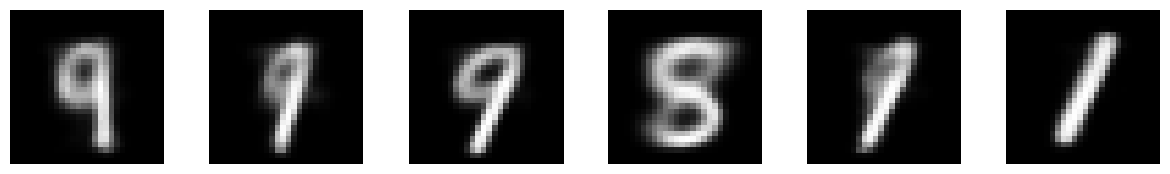


##################################################
VAE-MLP Epoch [9/10], Loss: 143.10862756347657
Sample Images:


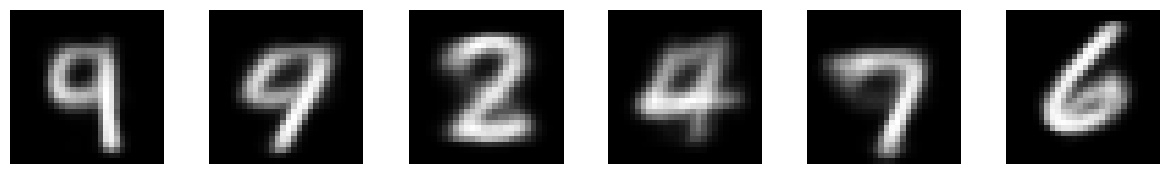


##################################################
VAE-MLP Epoch [10/10], Loss: 142.6850513997396
Sample Images:


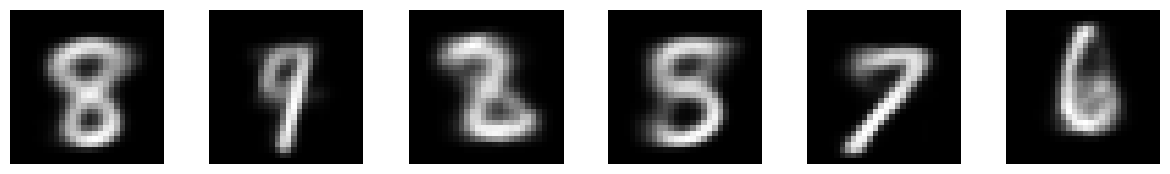

Best model saved as 'best_vae_mlp_model.pth'


In [15]:
# Train VAE-MLP
input_dim = 28 * 28  # MNIST images are 28x28
hidden_dim = 500     # Size for hidden dimensions
latent_dim = 2       # Size of the latent space

vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [9]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim + num_classes, hidden_dim),  # Concatenated input and class
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)  # Class prediction

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim + num_classes, hidden_dim),  # Concatenated latent and class
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Use Sigmoid to output values between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y], dim=1)

        # TODO: Implement the forward pass
        # Forward pass through encoder
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)

        # Reparameterization trick
        z = torch.cat([self.reparameterize(mu, logvar), y], dim=1)

        class_logits = self.fc_class(hidden)

        # Decoder to reconstruct the input
        reconstructed = self.decoder(z)

        return reconstructed, mu, logvar, class_logits


In [10]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.view(data.size(0), -1)
    # recon = recon.view(data.size(0), -1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels)

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return reconstruction_loss + kl_divergence + ce_loss


In [11]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=10)
            # labels_one_hot = labels_one_hot.type(torch.float32)  # Ensure float type for computation

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            # Forward pass through the model
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 156.50592663574218
Sample Images:


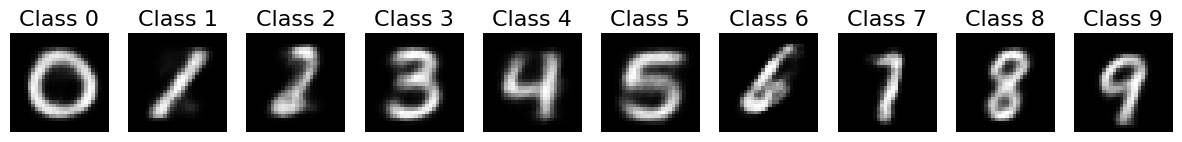


##################################################
CVAE-MLP Epoch [2/10], Loss: 136.88260259602865
Sample Images:


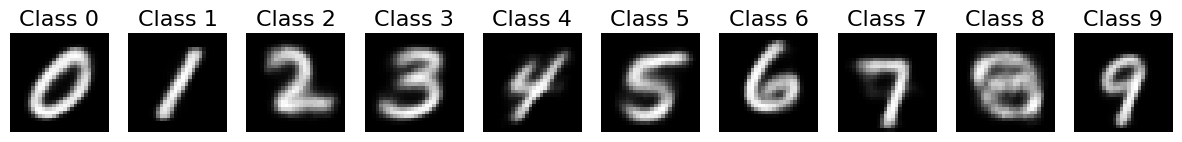


##################################################
CVAE-MLP Epoch [3/10], Loss: 133.8593843343099
Sample Images:


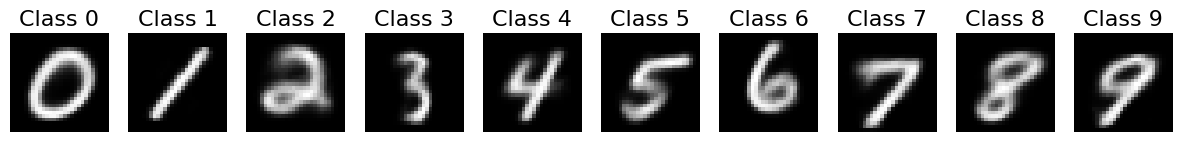


##################################################
CVAE-MLP Epoch [4/10], Loss: 132.51576256510415
Sample Images:


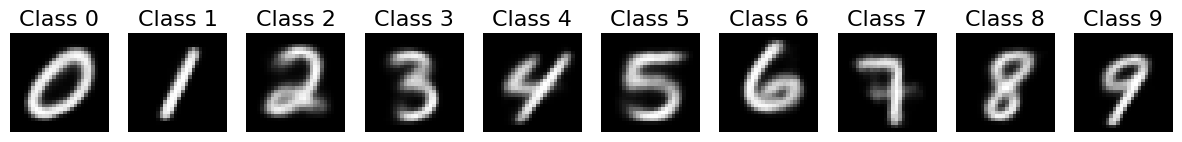


##################################################
CVAE-MLP Epoch [5/10], Loss: 131.6059078857422
Sample Images:


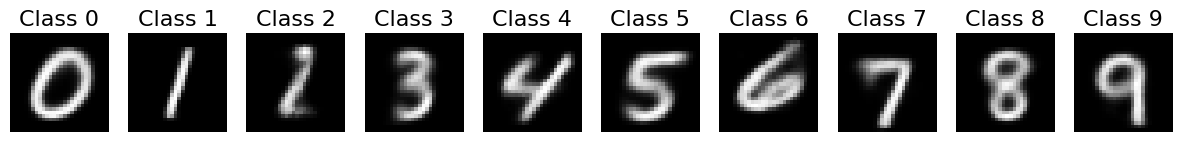


##################################################
CVAE-MLP Epoch [6/10], Loss: 130.9547287109375
Sample Images:


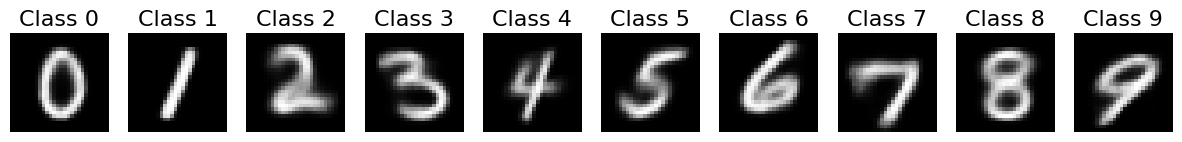


##################################################
CVAE-MLP Epoch [7/10], Loss: 130.3735587402344
Sample Images:


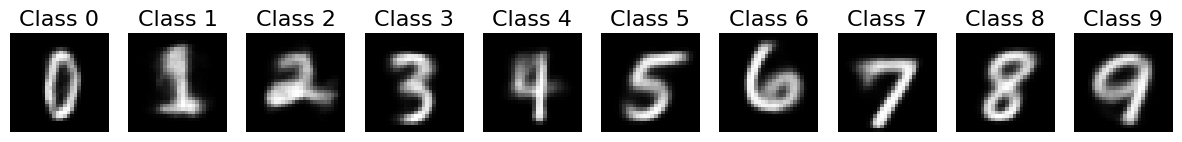


##################################################
CVAE-MLP Epoch [8/10], Loss: 129.92646990559896
Sample Images:


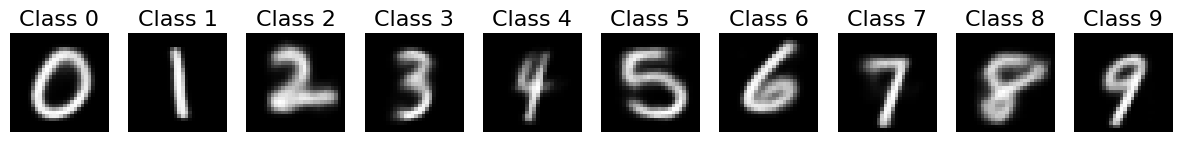


##################################################
CVAE-MLP Epoch [9/10], Loss: 129.46144639485678
Sample Images:


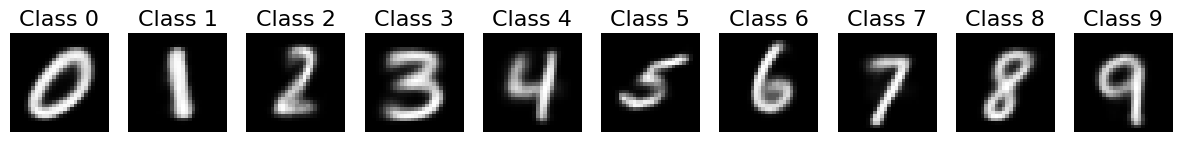


##################################################
CVAE-MLP Epoch [10/10], Loss: 129.0121568033854
Sample Images:


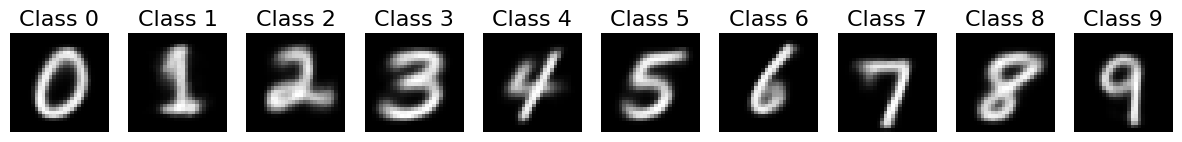

Best model saved as 'best_cvae_mlp_model.pth'


In [16]:
input_dim = 28 * 28  # MNIST images are 28x28
hidden_dim = 500     # Example size for hidden dimensions
latent_dim = 2       # Size of the latent space
num_classes = 10     # Number of classes in the MNIST dataset

cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


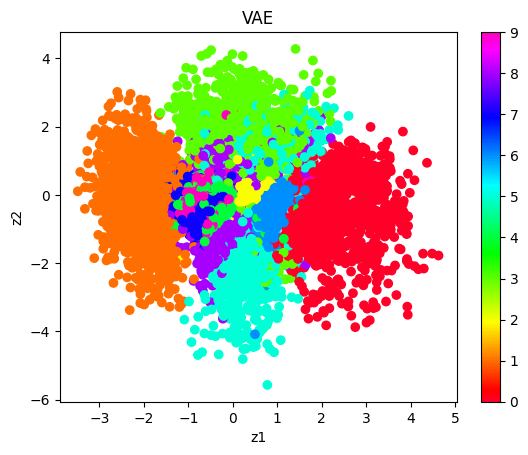

In [54]:
def visualize_latent_space_vae(model, data_loader, num_batches=None):
    model.eval()
    all_z = []
    all_labels = []

    with torch.no_grad():
        for i, (data, labels) in enumerate(data_loader):
            data = data.view(data.size(0), -1)  # Flatten the data
            encoded = model.encoder(data)
            # Obtain the latent space representation
            mu = model.fc_mu(encoded)
            logvar = model.fc_logvar(encoded)
            z = model.reparameterize(mu, logvar)  # Reparameterize to get z

            all_z.append(z)
            all_labels.append(labels)

            if num_batches is not None and i >= num_batches - 1:
                break

    # Concatenate all collected batches
    all_z = torch.cat(all_z, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Plot the accumulated points
    plt.scatter(all_z[:, 0].numpy(), all_z[:, 1].numpy(), c=all_labels.numpy(), cmap='gist_rainbow')
    plt.colorbar()
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('VAE')
    plt.show()

# Call the function with the VAE model and data loader
visualize_latent_space_vae(vae_mlp, train_loader, num_batches=200)  # For example, visualize 200 batches

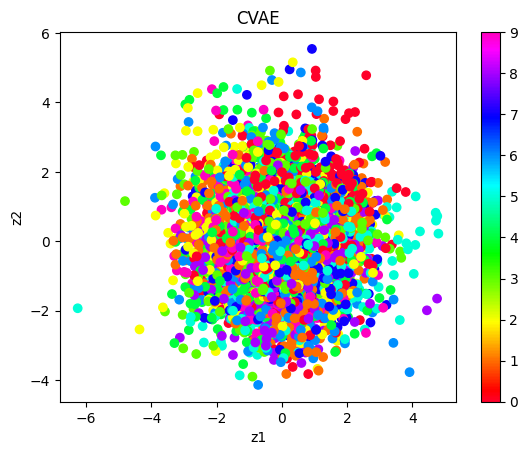

In [55]:
def visualize_latent_space_cvae(model, data_loader, num_batches=None):
    model.eval()
    all_z = []
    all_labels = []

    with torch.no_grad():
        for i, (data, labels) in enumerate(data_loader):
            data = data.view(data.size(0), -1)  # Flatten the data
            labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=10).type(torch.float32)
            encoded = model.encoder(torch.cat([data, labels_one_hot], dim=1))
            mu = model.fc_mu(encoded)
            logvar = model.fc_logvar(encoded)
            z = model.reparameterize(mu, logvar)

            all_z.append(z)
            all_labels.append(labels)

            if num_batches is not None and i >= num_batches - 1:
                break

    # Concatenate all collected batches
    all_z = torch.cat(all_z, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Plot the accumulated points with the 'hsv' colormap
    scatter = plt.scatter(all_z[:, 0].numpy(), all_z[:, 1].numpy(), c=all_labels.numpy(), cmap='gist_rainbow')
    plt.colorbar(scatter)
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('CVAE')
    plt.show()

# Call the function with the CVAE model and data loader
visualize_latent_space_cvae(cvae_mlp, train_loader, num_batches=200)  # For example, visualize 200 batches

###Conclusions based on the observed differences in the latent space distribution of VAE (MLP) and CVAE (MLP):

The VAE seems to create a more classically separated latent space conducive to clear class differentiation, while the CVAE displays a latent space with a more mixed representation, which might be advantageous for blending features from different classes. More specific conclusions are :

**Cluster Formation in VAE**:

The VAE plot shows distinct clusters of data points, with some overlap. Each cluster corresponds to a different digit, indicating that the VAE has learned a representation that groups similar digits together. This suggests good class separation, which is beneficial for tasks like digit classification and generation.

**Dispersion in CVAE**:

The CVAE plot shows a more dispersed distribution of points, with significant overlap between different colors/classes. While the conditional nature of the CVAE aims to control the generation process, the overlap suggests that the latent space does not distinctly separate the digits. This could mean that the CVAE might generate digits with characteristics of multiple classes.

**Interpretation of Latent Space**:

The VAE latent space indicates a model that might have better discriminative power for different digits, useful in classification. The CVAE latent space, while less discriminative, might be better suited for generating variations within digit classes, as it seems to represent a more continuous transition between digits.

**Implications for Generation**:

The clearer separation in the VAE latent space suggests that generating a new sample of a specific digit would result in a more accurate and class-consistent output. In contrast, the CVAE might produce new samples that are less class-consistent but could potentially exhibit more intra-class variability.